# Keeping a pendulum upright!


## 1. Project Setup

### 1.1 Environment Information
In this project, we are tasked to create a suitable modification of deep Q-network (DQN) architecture to the problem. From gymlibrary's documentation, here's what we know about our task:

<center>

> The inverted pendulum swingup problem is based on the classic problem in control theory. The system consists of a pendulum attached at one end to a fixed point, and the other end being free. The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.


</center>

Firstly, lets take a look at some of the variables we need to understand that were given to us.

- Action Space

According to a research available at ACM Digital Library [[]](https://dl.acm.org/doi/fullHtml/10.1145/3508546.3508598), action spaces are defined as

> "the set of all effective actions of the agent, [which has 2 properties], completeness and validity. Completeness guarantees the possibility that the agent can achieve the expected goal. If a certain action is missing, the agent has a high probability of failing to complete the task. An example of this is that a car must have the function of accelerating, decelerating, turning and braking to ensure safety. The validity requires that the actions in the action space must be legal, and you can never add the function of flying to the action space of driving car."

We believe that in this case, the action space is rather simple, as given by the website.

|Action|Min|Max|
|:-----:|:-----:|:-----:|
|Torque|-2.0|2.0|

To summarise, this just means that the pendulum only has one action, but in 2 states, which is a measurement of the force that can cause an object to rotate about an axis. The positive direction in this case is counter-clockwise, and the negative value goes in clockwise direction. This means that when the pendulum swings in a counter clockwise motion, it has a positive torque, and a negative torque when it swings in a clockwise motion.

- Observation Space

From the documentation, the observation is a ndarray with shape (3,) representing the x-y coordinates of the pendulum’s free end and its angular velocity.

|Num|Observation|Min|Max|
|:-----:|:-----:|:-----:|:----:|
|0| $x = cos(\theta)$ |-1.0|1.0|
|1| $y = sin(angle)$ |-1.0|1.0|
|2|Angular Velocity|-8.0|8.0|


- Rewards


Again from the documentation, the reward function is defined as:

$ r = -(\theta^2 + 0.1 * \theta_dt^2 + 0.001 * torque^2)$

where $\theta$ is the pendulum’s angle normalized between [-pi, pi] (with 0 being in the upright position). Based on the above equation, the minimum reward that can be obtained is $-(pi^2 + 0.1 * 8^2 + 0.001 * 2^2)$ = -16.2736044, while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied).


In [3]:
# pip install --quiet gymnasium wandb tensorflow==2.10.0 pandas

Note: you may need to restart the kernel to use updated packages.


### 1.2 Import Packages and Environment

In [3]:
import os
import json
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

from PIL import Image
import PIL.ImageDraw as ImageDraw
import imageio
import os
import wandb
from time import time


import pandas as pd
import sys

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import random
from keras.regularizers import l2

In [8]:
env = gym.make('Pendulum-v1', g=9.81)

In [9]:
print("Number of Activation Space: {}".format(env.action_space))

Number of Activation Space: Box(-2.0, 2.0, (1,), float32)


In [10]:
obs_space = env.observation_space.shape
print("Number of Observation Space: {}".format(obs_space))

Number of Observation Space: (3,)


### 1.3 What is Reinforcement Learning?
Reinforcement Learning(RL) is a type of machine learning technique that enables an agent to learn in an interactive environment by trial and error using feedback from its own actions and experiences,guided by feedbacks of rewards or penalties. The main objective is to discover strategies or policies that lead to the maximum cumulative rewards.

<img src = "https://miro.medium.com/v2/resize:fit:720/format:webp/1*7cuAqjQ97x1H_sBIeAVVZg.png" style="width:40%">

#### What makes a reinforcement learning problem?
- __Environment__ — Physical world in which the agent operates
- __State__ — Current situation of the agent
- __Reward__ — Feedback from the environment
- __Policy__ — Method to map agent’s state to actions
- __Value__ — Future reward that an agent would receive by taking an action in a particular state

When someone thinks about AI in general, they would usually think of some form of application by reinforcement learning, escpically through games. For example in the game flappy bird, where the main goal of the game is to fly through the green pipes and avoiding banging into them. In this case, the grid world is the interactive environment for the agent where it acts.The agent receives a reward for passing through the pipe and punishment if it collides with the pipes (loses the game). The states are the location of the agent in the grid world and the total cumulative reward is the agent getting the highest score possible.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*z-fUWDsJ4qAYIs63uQuTDA.png" style="width: 50%">

[[Source]](https://towardsdatascience.com/reinforcement-learning-an-introduction-to-the-concepts-applications-and-code-ced6fbfd882d)

However, to create the most optimal plan.the agent deals with a choice between exploring new situations and exploiting what it already knows to maximize rewards. This balancing act is called `Exploration vs Exploitation`. To find the most effective long-term strategy, the agent might need to give up some short-term gains. It's like trying out new things while also sticking to what works well, ensuring the agent collects enough information to make smarter decisions in the future.

#### Different Types of Stratgies for updating our agent's policy

__On-Policy__:
On-policy learning algorithms optimize the same policy (target policy) being used to select actions (behavioural policy) following some strategy (epsilon greedy).  In other words the agent updates its policy based on the data generated by its current policy. Where the agent learns from its own actions and experiences, making adjustments to its strategy as it goes.

__Off-Policy__:
Off-policy learning algorithms are different from on-policy methods because what is being learned/optimized is target policy and not the behavioural policy. Which means that the agent learns from data generated by a different (potentially older) policy than the one it's currently following. Thus the agent can learn from past experiences, even if those experiences were generated by a different strategy.

## 2. Baseline Model (DQN)
Deep Q learning is an improvement over vanilla Q learning , introduced by DeepMind, a British artificial intelligence company, in 2015[[]](https://www.nature.com/articles/nature14236). To understand DQN, we first need to talk about how Q learning works.

### The Q-Learning Algorithm:

<img src="https://images.datacamp.com/image/upload/v1666973295/Q_Learning_Process_134331efc1.png" style="width:20%">

[[Source]](https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial)

- 1. We first initialise our __Qtable__
- 2. Next we choose an action using the __Epsilon-Greedy Exploration Strategy__
- 3. Then update the Q-table using the __Bellman Equation__

#### Qtable:
We use a qtable to keep track of the states, actions, and their expected rewards. It maps a state-action pair to a Q-value (the estimated optimal future value) which our agent will learn. At the start of the Q-Learning algorithm, the Q-table is initialized to all zeros indicating so that our agent doesn’t know anything about the world. As our agent tries out different actions at different states through trial and error, our agent learns each state-action pair’s expected reward and updates the Q-table with the new Q-value. Using trial and error to learn about the world is called __Exploration__.

One of the main goals of Q learning is for the algorithm to learn the q vlaue for a new enviroment. Where the Q value is the maximum expected reward an agent can reach by taking a given action A from the state S.After an agent has learned the Q-value of each state-action pair, our agent at state S maximizes its expected reward by choosing the action A with the highest expected reward. Explicitly choosing the best known action at a state is called __Exploitation__.

#### Epsilon-Greedy Exploration Strategy:
One strategy to help balance exploration vs explotation is the epsilon greedy strategy. The way that this strategy works is that:

- 1. Eveytime it chooses an action, roll a probabilty
- 2. If the probabilty is lesser than epsilon, choose a random action (Exploration)
- 3. Else take best known action in its current state (Exploit)

When training an DQN, every step our agent will take will be random due it being useful in helping the agent learn more about the environment it's in. As our agent takes more and more steps, the value of epsilon decreases and our agent starts to try existing known good actions more and more. However, through research (M Gimelfarb et al. 2020 [[]](https://arxiv.org/pdf/2007.00869.pdf)), we found that epsilon-greedy is better for categorical/discrete action spaces. Hence, this left us with 2 choices:

- Making the action space discrete so as to ensure our DQN consistently exploits when the epsilon hits the minimum value we set,
- Finding another method that works well with continuous action spaces.

#### What is the Bellman Equation?
The Bellman Equation tells us how to update our Q-table after each step we take. In where our agent updates the current perceived value with the estimated optimal future reward which assumes that our agent takes the best current known action. So it will search through all the actions for a particular state and choose the state-action pair with the highest corresponding Q-value.

$$ Q(s, a) = R(s, a) + \gamma \cdot \max_{a'} Q(s', a') $$

where:
- $S$ = the State or Observation
- $A$ = the Action the agent takes
- $R$ = the Reward from taking an Action
- $t$ = the time step
- $Ɑ$ = the Learning Rate
- $ƛ$ = the discount factor which causes rewards to lose their value over time so more immediate rewards are valued more highly



<!-- md for policy decision, model decision etc -->

## Hyperparameters
For all our models and experiments, we have choosen to train our agent for a total of 200 episodes due to hardware and time limitations. Also due do hardware contraints of our machines, we have chose to store up to 5,000 experiences in the replay buffer to be sampled from.

We choose to keep the exploration rate of 1 as we would want our agent to explore the evironment before starting to learn from past experiences as slowly decay epsilon by a factor of $$(0.01 / epsilon) ** (1/training_episodes)$$ (Where the amount of episodes to decay from 1.0 to 0.01) with a minimum value of episolon being 0.01.

With experimenting with different learning rates and gamma, we have decided to use a learning rate of 0.0009 and a gamma of 0.99.

## Deep Q Network
The main difference between Q learning and DQN is how it stores and keeps track of its states and actions and reward(q value).Deep Q-Learning replaces the regular Q-table with a neural network. Rather than mapping a state-action pair to a q-value, a neural network maps input states to (action, Q-value) pairs. Where DQN introduces experience replay and target networks to stabilize training by breaking correlations between consecutive experiences and reducing target value fluctuations.[[]](https://www.researchgate.net/publication/352158682_hbox_CDBTune_An_efficient_deep_reinforcement_learning-based_automatic_cloud_database_tuning_system?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6InB1YmxpY2F0aW9uIiwicGFnZSI6Il9kaXJlY3QifX0#pf7)

Its steps goes on like this:
- 1. We initialize our neural networks
- 2. Then choose an action using the Epsilon-Greedy Exploration Strategy
- 3. Lastly update your network weights using the Bellman Equation

__How is it better than Q learning?[[]](https://www.baeldung.com/cs/q-learning-vs-deep-q-learning-vs-deep-q-network)__
- It is more scalable and can handle high-dimensional state spaces, making it suitable for complex environments. 
- The use of neural networks allows DQN to generalize across similar states, reducing the need for explicit storage of all state-action pairs.
- Experience replay improves the efficiency of learning by reusing past experiences, leading to more stable and effective training.

In [ ]:
class DQN:
    def __init__(self, env, lr, gamma, epsilon, epsilon_decay, epsilon_min=0.01, batch_size=64, fname='DQN2'):
        self.env = env        
        self.action_size = 9
        self.action_space = [n for n in range(self.action_size)]
        self.discrete_actions = np.linspace(-2.0, 2.0, num=self.action_size)
        

        self.alpha = lr  # learning rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        self.fname = fname
        self.memory = ReplayBuffer(5000, self.state_size, self.action_size)
        self.dqn_model = self.create_dqn('DQN-Model')
        self.update_counter = 0
        self.dqn_target_model = self.create_dqn('DQN-Target-Model')

    def create_dqn(self, name):
        model = Sequential([
            Dense(units=64, activation='relu', input_shape=(self.state_size,)),
            Dense(units=64, activation='relu'),
            Dense(units=self.action_size, activation='linear')
        ], name=name)

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.alpha))
        return model

    def remember(self, state, action, reward, new_state, done):
        self.memory.append(state, action, reward, new_state, done)

    def act(self, state):

        '''
        episilon greedy
        return argmax of q_values
        '''
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_values = self.dqn_model.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def update(self):
        if self.memory.memory_counter > self.batch_size:
            state, action, reward, new_state, done = self.memory.sample(self.batch_size)

            q_current = self.dqn_model.predict(state, verbose=0)
            q_future = self.dqn_model.predict(new_state, verbose=0)
            q_target = q_current.copy()

            for i in range(self.batch_size):
                q_target[i, action[i]] = reward[i] + self.gamma * np.max(q_future[i]) * done[i]

            self.dqn_model.fit(x=state, y=q_target, verbose=0)

    def train(self, n_episodes, max_steps=200, log_wandb=False,
              update=True, save_episodes=True, save_interval=10):
        history = {'reward': [], 'avg_reward_100': [], 'steps': []}

        for episode in range(n_episodes):
            start_time = time()
            state , info= self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            episode_reward = 0
            episode_steps = 0
            episode_frames  = []

            for _ in range(max_steps):
                action = self.act(state)
                new_state, reward, done, _, _ = self.env.step([self.discrete_actions[action]])
                new_state = np.reshape(new_state, [1, self.state_size])
                episode_frames.append(self.env.render())

                if update:
                    self.remember(state, action, reward, new_state, done)
                    self.update()

                state = new_state
                episode_reward += reward
                episode_steps += 1

                if done:
                    break

            if log_wandb:
                wandb.log({
                    'reward': episode_reward,
                    'steps': episode_steps,
                    'epsilon': self.epsilon
                })

            if save_episodes:
                if (episode + 1) % save_interval == 0 or (episode == 0):
                    s = MyEpisodeSaver(self.env, episode_frames , self.fname, episode + 1)
                    s.save()

            print(f'[EP {episode + 1}/{n_episodes}] - Reward: {episode_reward:.4f} - Steps: {episode_steps} - Eps: {self.epsilon:.4f} - Time: {time() - start_time:.2f}s')
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            history['reward'].append(episode_reward)
            history['avg_reward_100'].append(np.mean(history['reward'][-100:]))
            history['steps'].append(episode_steps)
            df = pd.DataFrame(history)
            df.to_csv(f'{self.fname}.csv', index=False)

        self.env.close()

        if log_wandb:
            wandb.finish()

        self.save(f'{self.fname}.h5')

        return history

    def save(self, fname):
        if not os.path.exists('./assets'):
            os.mkdir('./assets')

        self.dqn_model.save(f'./assets/{fname}')

    def load(self, fname):
        self.dqn_model = load_model(f'./assets/{fname}')

### 2.1 Evaluation

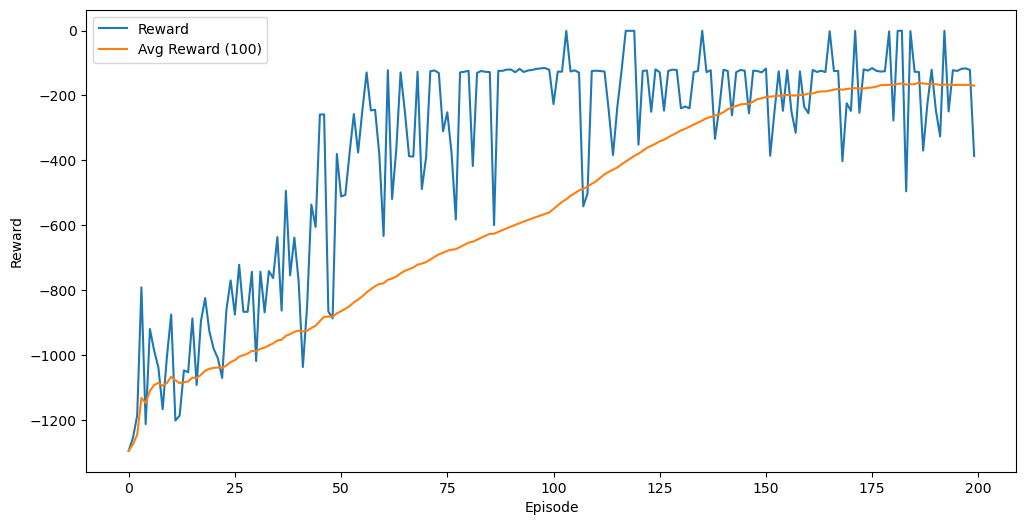

In [8]:
dqn_df = pd.read_csv('./models/assets/DQN.csv')

plt.figure(figsize=(12, 6))
plt.plot(dqn_df['reward'], label='Reward')
plt.plot(dqn_df['avg_reward_100'], label='Avg Reward (100)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()


__Episode 80:__

![test](models\gifs\DQN\episode_80.gif)

__Episode 180:__

![test](models\gifs\DQN\episode_180.gif)

### 2.2 __Observations:__

As seen by the graph, the DQN converges at about 175 episodes by looking at the average rewards obtained throughout the episodes. However, there is a problem of spiking, which could be caused by the overestimation through the network. Overestimation tends to introduce bias into the training process. The Q-values are used to calculate the temporal difference (TD) error, which is the difference between the predicted Q-value and the target Q-value. Biased estimates can lead to inaccurate TD errors, potentially causing instability during training. To solve this, we will need to use models that can help mitigate this issue.

One other observation is that it plateaus for very long at about -200. This means that it may be possible to end the training earlier, or try to allow it to explore more, which helps it learn the actions better. 

##  3. Model Selection

Next, to improve our model, we aim to look at multiple ways in order to either make the DQN more complex, or fix the issues that it has, from research through papers and forums[[]](https://arxiv.org/pdf/1511.06581.pdf): 

- Traditional DQN tends to overestimate Q-values, which can lead to suboptimal policies.
- DQN often spends unnecessary resources learning state values, even when they are not critical for decision-making.
- DQN might struggle with exploration, especially in environments with large action spaces.



### 3.1 Double DQN

Deep Q-Learning (DQN) is a reinforcement learning algorithm that combines deep neural networks with Q-learning to enable agents to learn optimal policies in complex environments. While DQN has shown success in various tasks, it has some limitations, such as overestimation of Q-values. Double Deep Q-Learning (Double DQN) addresses this issue by introducing a mechanism to mitigate the overestimation bias, leading to more stable and accurate learning. In standard DQN, the max operator is applied to the same Q-network for both selecting and evaluating actions. This can lead to overestimation of Q-values, especially when the Q-values are noisy or when there are large variations in action values. The overestimation bias arises because the same set of weights is used to estimate the maximum Q-value and the Q-value for the selected action, potentially leading to an optimistic bias in the learned Q-values. This can be seen through some tests that were performed in order to compare DQN and Double DQN in different games/environments:


<center>
<img src = "https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-03_at_2.22.18_PM.png" width = 40%>
</center>

As we can see from their observation, they yield the same gradients in terms of value estimates, as they are using the same type of network (DQN). However, the values are drastically different. Hence, this shows how DDQN aims to help mitigate this overestimation problem. Double DQN addresses the overestimation bias by decoupling the action selection and evaluation processes. It introduces two separate Q-networks: the main Q-network and the target Q-network. The target Q-network is used for action selection, while the main Q-network is used for action evaluation.


In [ ]:
import imageio, random
import pandas as pd
class DDQN:
    def __init__(self, env, lr, gamma, epsilon, epsilon_decay, epsilon_min=0.01, batch_size=128, fname='DDQN'):
        self.env = env
        self.action_size = 10
        self.state_size = env.observation_space.shape[0]
        self.action_space = [i for i in range(self.action_size)] 
        self.discrete_actions = np.linspace(-2.0, 2.0, num = self.action_size)

        self.alpha = lr 
        self.gamma = gamma
        self.epsilon = epsilon
        self.tau = 0.01
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update_interval = 100

        self.fname = fname
        self.memory = ReplayBuffer(5000, self.state_size, self.action_size)
        self.dqn_model = self.create_dqn('DQN-Model')
        self.update_counter = 0
        self.dqn_target_model = self.create_dqn('DQN-Target-Model')


    def create_dqn(self, name):
        model = Sequential([
            Dense(units=64, activation='leaky_relu', input_shape=(self.state_size,)),
            Dense(units=32, activation='leaky_relu'),
            Dense(units=self.action_size, activation='linear')
        ], name=name)

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.alpha))
        return model

    def remember(self, state, action, reward, new_state, done):
        self.memory.append(state, action, reward, new_state, done)

    def act(self, state):
        state = np.reshape(state, [1, self.state_size])
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_values = self.dqn_model.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def update(self):
        if self.memory.memory_counter > self.batch_size:
            state, action, reward, new_state, done = self.memory.sample(self.batch_size)

            q_current = self.dqn_target_model.predict(new_state, verbose=0) 
            q_future = self.dqn_model.predict(new_state, verbose=0)
            q_target = self.dqn_model.predict(state, verbose=0)

            best_actions = np.argmax(q_current, axis=1)

            for i in range(self.batch_size):
                q_target[i, action[i]] = reward[i] + self.gamma * q_future[i, best_actions[i]] * done[i]

            self.dqn_model.fit(x=state, y=q_target, verbose=0)
            self.update_counter += 1

            # soft update with tau
            main_weights = self.dqn_model.get_weights()
            target_weights = self.dqn_target_model.get_weights()

            for i in range(len(target_weights)):
                target_weights[i] = self.tau * main_weights[i] + (1 - self.tau) * target_weights[i]
            
            self.dqn_target_model.set_weights(target_weights)

    def train(self, n_episodes, max_steps=200, log_wandb=False,
              update=True, save_episodes=False, save_interval=10):
        history = {'reward': [], 'avg_reward_100': [], 'steps': []}

        for episode in range(n_episodes):

            start_time = time()
            state, info = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            episode_reward = 0
            episode_steps = 0
            episode_frames  = []

            for _ in range(max_steps):
                action = self.act(state)

                new_state, reward, done, _, _ = self.env.step([self.discrete_actions[action]]) # 5 values returned
                
                new_state = np.reshape(new_state, [1, self.state_size])
                episode_frames.append(self.env.render())

                if update:
                    self.remember(state, action, reward, new_state, done)
                    self.update()

                state = new_state
                episode_reward += reward
                episode_steps += 1

                if done:
                    break

            if log_wandb:
                wandb.log({
                    'reward': episode_reward,
                    'steps': episode_steps,
                    'epsilon': self.epsilon
                })

            if save_episodes:
                if (episode + 1) % save_interval == 0 or (episode == 0):
                    s = MyEpisodeSaver(self.env, episode_frames , self.fname, episode + 1)
                    s.save()

            print(f'[EP {episode + 1}/{n_episodes}] - Reward: {episode_reward:.4f} - Steps: {episode_steps} - Eps: {self.epsilon:.4f} - Time: {time() - start_time:.2f}s')
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            history['reward'].append(episode_reward)
            history['avg_reward_100'].append(np.mean(history['reward'][-100:]))
            history['steps'].append(episode_steps)
            df = pd.DataFrame(history)
            df.to_csv(f'./assets/{self.fname}.csv')

        self.env.close()

        if log_wandb:
            wandb.finish()

        self.save(f'{self.fname}.h5')

        return history

    def save(self, fname):
        if not os.path.exists('./assets'):
            os.mkdir('./assets')

        self.dqn_model.save(f'./assets/{fname}')

    def load(self, fname):
        self.dqn_model = load_model(f'./assets/{fname}')

### 3.2 Evaluation

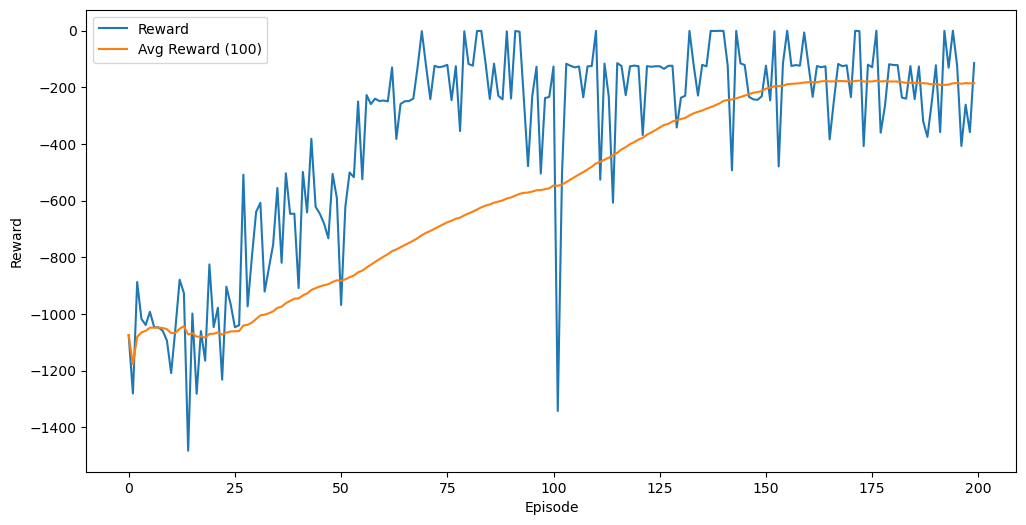

In [4]:
double_dqn_df = pd.read_csv('./models/assets/DDQN.csv')

plt.figure(figsize=(12, 6))
plt.plot(double_dqn_df['reward'], label='Reward')
plt.plot(double_dqn_df['avg_reward_100'], label='Avg Reward (100)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()


__Episode 80:__

![test](models\gifs\DDQN\episode_80.gif)

__Episode 180:__

![test](models\gifs\DDQN\episode_180.gif)

### 3.3 __Observations:__
We can see that as compared to the baseline DQN, our DDQN converges earlier at around 150 epochs, as seen by the plateauing. It suggests that our ddqn is more sample-efficient in learning the optimal policy and it manages to leverage past experiences more effectively However, we can see that our DDQN is a little bit more unstable during its training, suggesting the need to prevent the model from oscillating or getting stuck in suboptimal policies.

Through these observations, we can also see that through the target network, the problem of overestimation is slightly fixed towards the end. Therefore, we can confidently state that the DDQN performs better than the DQN due to its stabilisation through a second network.

### 3.3 Dueling DQN

From the paper stated at first, this is how Dueling DQNs are described:

<center>

> This dueling network should be understood as asingle Q network with two streams that replaces the popular single-stream Q network in existing algorithms such as Deep Q-Networks. The dueling network automatically produces separate estimates of the state value function and advantage function. Intuitively, the dueling architecture can learn which states are (or are not) valuable, without having to learn the effect of each action for each state. This is particularly useful in states where its actions do not affect the environment in any relevant way. The key insight behind our new architecture, [...] is that for many states, it is unnecessary to estimate the value of each action choice. In this case, its a different ball game. 

</center>

We can assume that the DQN only needs to know the angular velocity produced by the torque at different positions, which is quite one dimensional. Hence, if our assumption is correct, the dueling dqn would work better in this scenario due to the dimensonality of the action space. Hence, we picked this model.

One such advantage of this model are that it has improved stability. The dueling architecture separates the estimation of the state value and the advantages of each action, allowing for more efficient learning. This separation can enhance the estimation of the value function, which are represented by V and A in our model during the building of the architecture. Traditional DQN architectures often face challenges related to the correlation between Q-values and the non-stationary nature of the target. By decoupling the value and advantage, Dueling DQN can mitigate issues related to these correlations, leading to more stable and faster convergence during training.

The value stream, V(s), represents the inherent value of being in a particular state, irrespective of the action taken. This stream captures the fundamental importance of the state itself. The advantage stream, A(s,a), represents the additional value of taking a specific action compared to the expected value in that state. This stream captures the relevance of each action with respect to the state.


This is an illustration of how it compares to the baseline DQN:

<center>

<img src = "https://miro.medium.com/v2/resize:fit:640/format:webp/1*KKR9bkqTIpisZzAadtu5-g.png">

_How a Dueling DQN works and the different streams_
</center>

There are a few requirements to build a Dueling DQN. In the same paper, this is what we need to do to apply a Dueling DQN:

- To bring this insight to fruition, we design a single Qnetwork architecture, which we refer to as the dueling network. 
- The lower layers of the dueling network are convolutional as in the original DQNs
- However, instead of following the convolutional layers with a single sequence of fully connected layers, we instead use two sequences (or streams) of fully connected layers
- Finally, the two streams are combined to produce a single output Q function

In [ ]:
class DuelingDQL:
    def __init__(self, env, alpha, gamma, epsilon, batch_size=64,
                epsilon_decay=1e-3, epsilon_min=0.01, replace=100, fname='Dueling_DQN'):
        self.env = env
        self.state_size = self.env.observation_space.shape[0]

        self.action_size = 9
        self.action_space = [n for n in range(self.action_size)]
        self.discrete_actions = np.linspace(-2.0, 2.0, num=self.action_size)

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.replace = replace
        self.batch_size = batch_size
        self.fname = fname

        self.update_counter = 0
        self.memory = ReplayBuffer(10_000, self.state_size, self.action_size)
        self.q_eval = DuelingDQN(self.action_size)
        self.q_next = DuelingDQN(self.action_size)

        self.q_eval.compile(optimizer=Adam(learning_rate=alpha), loss='mse')

    def remember(self, state, action, reward, new_state, done):
        self.memory.append(state, action, reward, new_state, done)

    def act(self, observation):
        state = np.array([observation])
        rand = np.random.random()

        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.advantage(state)
            action = np.argmax(actions)

        return action

    def update(self):
        if self.memory.memory_counter < self.batch_size:
            return

        states, actions, rewards, states_, dones = self.memory.sample(self.batch_size)

        q_pred = self.q_eval(states)
        q_next = tf.math.reduce_max(self.q_next(states_), axis=1, keepdims=True).numpy()
        q_target = np.copy(q_pred)

        for idx, terminal in enumerate(dones):
            if terminal:
                q_next[idx] = 0.0
            action_idx = actions[idx]
            q_target[idx, action_idx] = rewards[idx] + self.gamma * q_next[idx]

        self.q_eval.train_on_batch(states, q_target)

        self.update_counter += 1

        if self.update_counter % self.replace == 0:
            self.update_target()

    def update_target(self):
        self.q_next.set_weights(self.q_eval.get_weights())

    def train(self, n_episodes, max_steps, log_wandb=False, update=True, save_episodes=False, save_interval=100):
        history = {'reward': [], 'avg_reward_100': [], 'steps': []}

        for episode in range(n_episodes):
            start_time = time()
            state = self.env.reset()
            state = state[0]
            done = False
            episode_reward = 0
            episode_steps = 0
            frames = []

            for _ in range(max_steps):
                action = self.act(state)
                new_state, reward, done, _, _ = self.env.step([self.discrete_actions[action]])
                frames.append(self.env.render())

                if update:
                    self.remember(state, action, reward, new_state, done)
                    self.update()

                state = new_state
                episode_reward += reward
                episode_steps += 1

                if done:
                    break

            if log_wandb:
                wandb.log({
                    'reward': episode_reward,
                    'steps': episode_steps,
                    'epsilon': self.epsilon
                })

            if save_episodes:
                if (episode + 1) % save_interval == 0 or (episode == 0):
                    s = EpisodeSaver(self.env, frames, self.fname, episode + 1)
                    s.save()

            history['reward'].append(episode_reward)
            history['avg_reward_100'].append(np.mean(history['reward'][-100:]))
            history['steps'].append(episode_steps)
            df = pd.DataFrame(history)
            df.to_csv(f'./assets/{self.fname}.csv', index=False)

            print(f'[EP {episode + 1}/{n_episodes}] - Reward: {episode_reward:.4f} - Steps: {episode_steps} - Eps: {self.epsilon:.4f} - Time: {time() - start_time:.2f}s')
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        self.env.close()

        if log_wandb:
            wandb.finish()

        self.save_model(self.fname)

        return history

    def save_model(self, fname):
        if not os.path.exists('./assets'):
            os.mkdir('./assets')

        self.q_eval.save(f'assets/{fname}', save_format='tf')

    def load_model(self, fname):
        self.q_eval = load_model(fname)

### 3.4 Evaluation

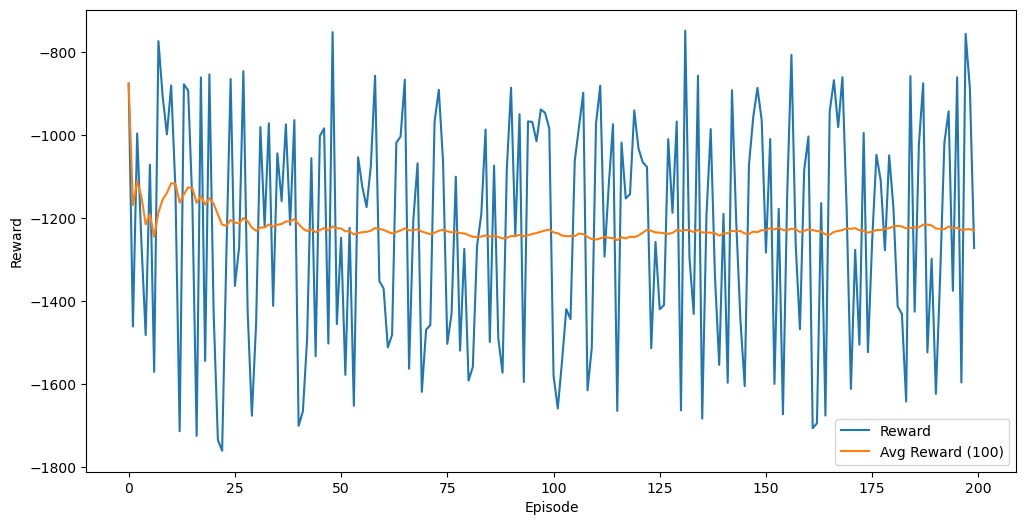

In [6]:
dueling_df = pd.read_csv('./models/assets/dueling_dql.csv')

plt.figure(figsize=(12, 6))
plt.plot(dueling_df['reward'], label='Reward')
plt.plot(dueling_df['avg_reward_100'], label='Avg Reward (100)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()



### 3.5 __Observations__

As we can see, the results are very sporadic. Despite applying the model correctly, it kept spiking between -800 to -1600. This could be due to a few things. One possibility is that our assumption of the low dimensonality of this environment for the Dueling DQN to work with was wrong, or it could also be possible that it's not learning properly. Hence, this shows that we will not be moving on with the Dueling DQN.

## 4. Model Improvement

## 4.1 Reward shaping
The main idea of reward shaping is is to transform possible domain knowledge into additional rewards and guide learning algorithms to learn faster and better with the combination of the original and new rewards, which can address the sample efficiency issue in training RLs.These intermediate rewards are designed to encourage desired behaviors or actions, contributing to a more focused learning trajectory. Early works of reward shapping can be n be dated back to the attempt of using hand-crafted reward function for robot behavior learning [[]](https://www.researchgate.net/publication/222481254_Robot_shaping_Developing_autonomous_agents_through_learning) and bicycle driving [[]](https://www.researchgate.net/publication/221346431_Learning_to_Drive_a_Bicycle_Using_Reinforcement_Learning_and_Shaping).

### How are we going to implement reward shaping in our reward function?
In our problem, the goal is to swing a pendulum and keep it upright. Where our oringinal reward function is:
$$
-theta^2 - 0.1*theta_dt^2 - 0.001*action^2
$$ 
 where $theta$ is the angle of the pendulum and $action$ is the torque applied. We have some ideas on how we would like to implement reward shaping in addition to our oringinal reward function.

__1. Penalize high torque__
- We could implement a penalty for high torque actions to encourage our agent to use smaller torques, which could help it to reduce oscillations:
$$reward -= 0.01 * |action|$$

__2. Reward our agent with getting closer to the upright position__
- We could also give our agent a small reward for decreasing the angle of the pendulum, which may help it inch closer to our goal of it being upright
$$reward += 0.1 * (\pi - |theta|)$$

__3. Penalize high angular velocity__
- Another way is to penalize our agent for high angular velocity to encourage our agent to stablize the pendulum.

$$reward -= 0.01 * |theta_dt|$$

We will be implementing 2 reward shaping methods in our model improvement, rewarding our agent with getting closer to the upright position and penalizing high angular velocity. 

<!-- We will not be implementing a penalty for high torque due to  -->

In [ ]:
def train(self, n_episodes, EpisodeSaver, max_steps=200, log_wandb=False,
              update=True, save_episodes=False, save_interval=10):
    history = {'reward': [], 'avg_reward_100': [], 'steps': []}

    for episode in range(n_episodes):
        # print(episode)
        start_time = time()
        state, info = self.env.reset()
        state = np.reshape(state, [1, self.state_size])
        done = False
        episode_reward = 0
        episode_steps = 0
        episode_frames  = []
            # self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        for _ in range(max_steps):
            action = self.act(state)

            new_state, reward, done, _, _ = self.env.step([self.discrete_actions[action]]) # 5 values returned
                
            theta = new_state[0]
            theta_dt = new_state[1]

            # Modify our reward
            reward = reward + (0.1 * (np.pi - np.abs(theta)))
            reward = reward - (0.01 * np.abs(theta_dt))

            new_state = np.reshape(new_state, [1, self.state_size])
            episode_frames.append(self.env.render())

            if update:
                self.remember(state, action, reward, new_state, done)
                self.update()

            state = new_state
            episode_reward += reward
            episode_steps += 1

            if done:
                break

## 4.2 Regularization
We use regularization to aim to help prevent overfitting and improving the generalization of our model.
### What does Regularization do in the context of RL?
Due to RL being a whole different ball game as compared to GANs, what is there to be prevented from overfitting? There are many benefits when it comes to including regularization in RL. In some examples such as the paper "Generalization and Regularization in DQN" by Jesse Farebrother, Marlos C. Machado, and Michael Bowling[[]](https://arxiv.org/pdf/1810.00123.pdf), where they explored the benefits of regularization in DQN through the Atari 2600 games.

Some benefits from regularization[[]](https://dl.acm.org/doi/pdf/10.5555/3495724.3496392):
- In the context of our problem, regularization can help prevent the agent from memorizing the training data excessively. As overfitting can lead to poor generalization to unseen states and actions.
- it encourages the learning of a smoother policy by penalizing complex or erratic policies. A smoother policy tends to generalize better to different situations thus improving our agent's adaptability.
- Regularization helps our agent to make the most of available data, optimizing its learning process and reducing the risk of overfitting.

In [ ]:
from keras.regularizers import l2
def create_dqn(self, name):
    model = Sequential([
        Dense(units=64, activation='leaky_relu', input_shape=(self.state_size,), kernel_regularizer=l2(0.01)),
        Dense(units=32, activation='leaky_relu', kernel_regularizer=l2(0.01)),
        Dense(units=self.action_size, activation='linear', kernel_regularizer=l2(0.01))
    ], name=name)

    model.compile(loss='mse', optimizer=Adam(learning_rate=self.alpha))
    return model

### 4.3 Final Model with all improvements

In [ ]:


class DDQN:
    def __init__(self, env, lr, gamma, epsilon, epsilon_decay, epsilon_min=0.01, batch_size=128, fname='DDQN_model_improvement'):
        self.env = env
        self.action_size = 10
        self.state_size = env.observation_space.shape[0]
        self.action_space = [i for i in range(self.action_size)] 
        self.discrete_actions = np.linspace(-2.0, 2.0, num = self.action_size)

        self.alpha = lr  # learning rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.tau = 0.01
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update_interval = 100

        self.fname = fname
        self.memory = ReplayBuffer(10000, self.state_size, self.action_size)
        self.dqn_model = self.create_dqn('DQN-Model')
        self.update_counter = 0
        self.dqn_target_model = self.create_dqn('DQN-Target-Model')


    def create_dqn(self, name):
        model = Sequential([
            Dense(units=64, activation='leaky_relu', input_shape=(self.state_size,), kernel_regularizer=l2(0.01)),
            Dense(units=32, activation='leaky_relu', kernel_regularizer=l2(0.01)),
            Dense(units=self.action_size, activation='linear', kernel_regularizer=l2(0.01))
        ], name=name)

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.alpha))
        return model

    def remember(self, state, action, reward, new_state, done):
        self.memory.append(state, action, reward, new_state, done)

    def act(self, state):
        state = np.reshape(state, [1, self.state_size])
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_values = self.dqn_model.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def update(self):
        if self.memory.memory_counter > self.batch_size:
            state, action, reward, new_state, done = self.memory.sample(self.batch_size)

            q_current = self.dqn_target_model.predict(new_state, verbose=0) 
            q_future = self.dqn_model.predict(new_state, verbose=0)
            q_target = self.dqn_model.predict(state, verbose=0)

            best_actions = np.argmax(q_current, axis=1)

            for i in range(self.batch_size):
                q_target[i, action[i]] = reward[i] + self.gamma * q_future[i, best_actions[i]] * done[i]

            self.dqn_model.fit(x=state, y=q_target, verbose=0)
            self.update_counter += 1

            # soft update with tau
            main_weights = self.dqn_model.get_weights()
            target_weights = self.dqn_target_model.get_weights()

            for i in range(len(target_weights)):
                target_weights[i] = self.tau * main_weights[i] + (1 - self.tau) * target_weights[i]
            
            self.dqn_target_model.set_weights(target_weights)

    def train(self, n_episodes, max_steps=200, log_wandb=False,
              update=True, save_episodes=True, save_interval=10):
        history = {'reward': [], 'avg_reward_100': [], 'steps': []}

        for episode in range(n_episodes):
            start_time = time()
            state, info = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            episode_reward = 0
            episode_steps = 0
            episode_frames  = []

            for _ in range(max_steps):
                action = self.act(state)

                new_state, reward, done, _, _ = self.env.step([self.discrete_actions[action]]) # 5 values returned
                
                theta = new_state[0]
                theta_dt = new_state[1]

                # Modify our reward
                reward = reward + (0.05 * (np.pi - np.abs(theta)))

                new_state = np.reshape(new_state, [1, self.state_size])
                episode_frames.append(self.env.render())

                if update:
                    self.remember(state, action, reward, new_state, done)
                    self.update()

                state = new_state
                episode_reward += reward
                episode_steps += 1

                if done:
                    break

            if log_wandb:
                wandb.log({
                    'reward': episode_reward,
                    'steps': episode_steps,
                    'epsilon': self.epsilon
                })

            if save_episodes:
                if (episode + 1) % save_interval == 0 or (episode == 0):
                    s = MyEpisodeSaver(self.env, episode_frames , self.fname, episode + 1)
                    s.save()

            print(f'[EP {episode + 1}/{n_episodes}] - Reward: {episode_reward:.4f} - Steps: {episode_steps} - Eps: {self.epsilon:.4f} - Time: {time() - start_time:.2f}s')
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            history['reward'].append(episode_reward)
            history['avg_reward_100'].append(np.mean(history['reward'][-100:]))
            history['steps'].append(episode_steps)
            df = pd.DataFrame(history)
            df.to_csv(f'./assets/{self.fname}.csv')

        self.env.close()

        if log_wandb:
            wandb.finish()

        self.save(f'{self.fname}.h5')

        return history

    def save(self, fname):
        if not os.path.exists('./assets'):
            os.mkdir('./assets')

        self.dqn_model.save(f'./assets/{fname}')

    def load(self, fname):
        self.dqn_model = load_model(f'./assets/{fname}')

### 4.4 Evalutation

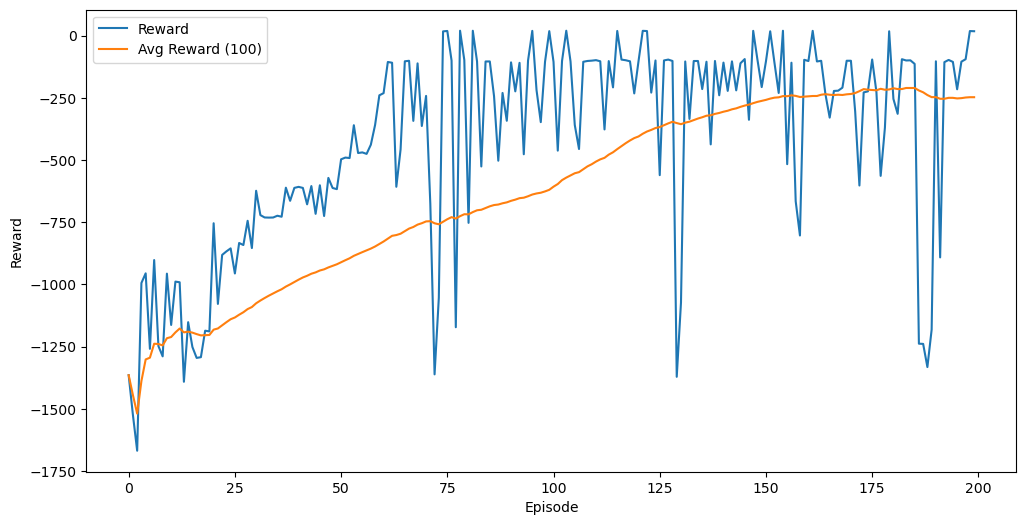

In [5]:
model_improvement_df = pd.read_csv('./models/assets/DDQN_model_improvement.csv')

plt.figure(figsize=(12, 6))
plt.plot(model_improvement_df['reward'], label='Reward')
plt.plot(model_improvement_df['avg_reward_100'], label='Avg Reward (100)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()


__Episode 80:__

![test](models\gifs\DDQN_model_improvement\episode_80.gif)

__Episode 180:__

![test](models\gifs\DDQN_model_improvement\episode_180.gif)

### 4.5 __Observations__:
Similar to our DDQN model, we see alot of training unstablilty, this could be due to a few reasons
    - Our inclusion of reward shapping may have interfered with our agent's abilty to assign credit to actions. With our agent's action leading to immediate shaped rewards but possibly negative long term consequence
    - It could be due to the increased variance reward shaping brings to the reward signal.

From this, we can see that it plateaus a lot slower than the regular DDQN, but hits values closer to 0 more often. Despite this, the results being very volatile is not a good sign, as seen from the rewards per episode dropping lower than -1000 at times, despite already converging.

## 5 Conclusion

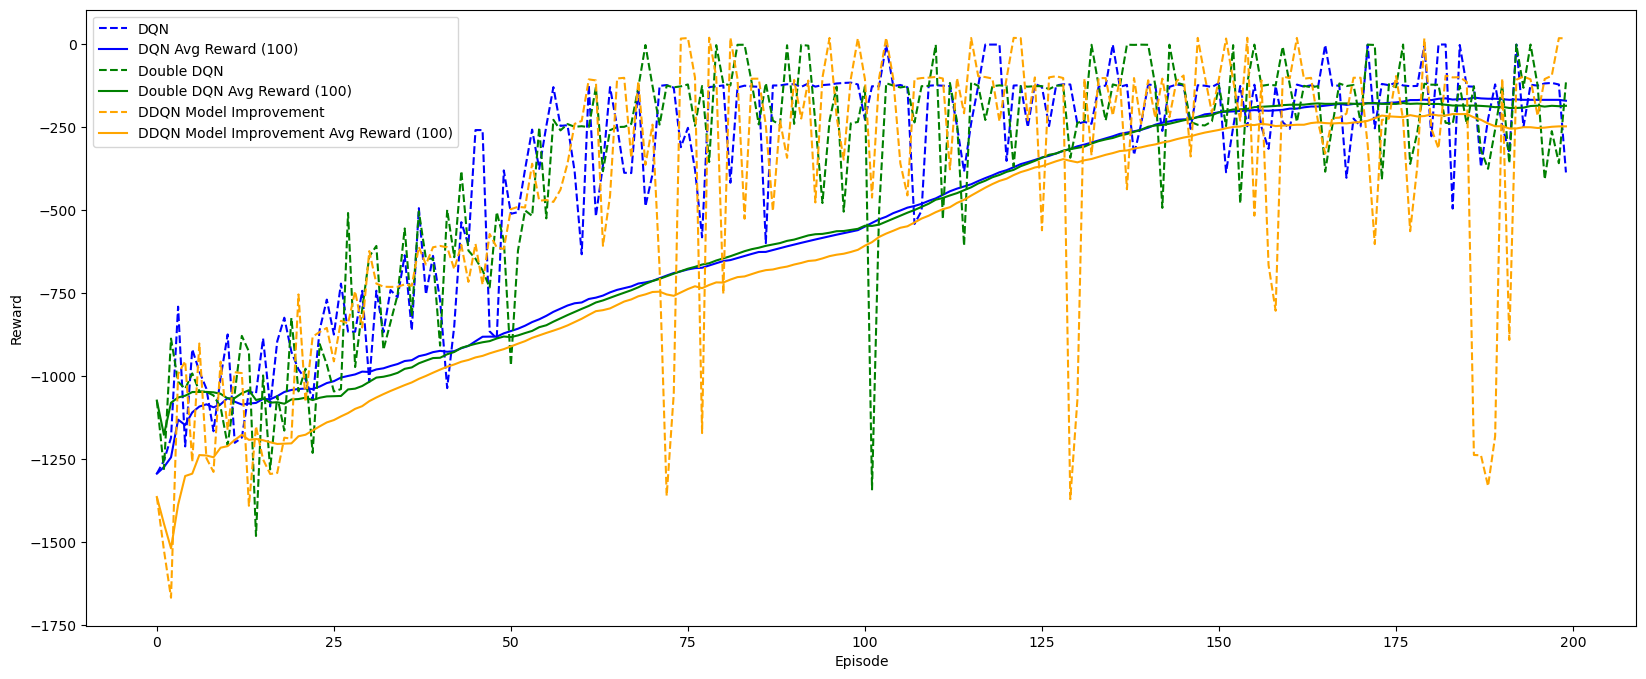

In [11]:
#plot all the models together
plt.figure(figsize=(20, 8))
plt.plot(dqn_df['reward'], label='DQN', color='blue',linestyle='--')
plt.plot(dqn_df['avg_reward_100'], label='DQN Avg Reward (100)', color='blue')
plt.plot(double_dqn_df['reward'], label='Double DQN', color='green',linestyle='--')
plt.plot(double_dqn_df['avg_reward_100'], label='Double DQN Avg Reward (100)', color='green')
plt.plot(model_improvement_df['reward'], label='DDQN Model Improvement', color='orange',linestyle='--')
plt.plot(model_improvement_df['avg_reward_100'], label='DDQN Model Improvement Avg Reward (100)', color='orange')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

In conclusion, we have implement 3 different reinforcement learning algorithms and have found the DQN agent to be the best out of three due to the slightly higher average rewards received after 200 episodes.

Despite our efforts in improving DDQN, the improved model actual performs a little worse as compare to the other 2 models.

With more time, we plan to experiment with several methods to enhance the convergence of each algorithm. We'll explore state discretization for improved representation, prioritize experience replay to focus on crucial transitions, increase memory capacity for a richer dataset, adjust training episodes to find optimal durations, and conduct hyperparameter tuning for better algorithm performance.

<img src="https://i.redd.it/sp0j7pyannv01.jpg" style="width:50%">

## 6. References